In [21]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

import joblib

from IPython.display import clear_output

#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['figure.figsize'] = 10, 6

## Model training

In [22]:
data_path = "/Users/oliverpaul/Data_Science/idiap/lucideles/data"
df = pd.read_csv(data_path+ "/data_transform", index_col=0)

In [23]:
df = df.drop(columns=['azimuth', 'month', 'day', 'hour'])

In [24]:
df.sample(5)

,blind angle,fully open,ibn,idh,altitude,azimuth_sin,azimuth_cos,dgp,ill
5962,0,1,1064,116,38.98970,0.752309,-0.658810,0.255206,717.383881
7627,0,1,0,0,-20.33000,-0.999999,-0.001157,0.002860,0.000000
69223,60,0,0,7,-8.19286,0.915103,-0.403221,0.003026,0.762514
29259,20,0,0,0,-19.03330,0.634653,0.772797,0.002860,0.000000
52795,50,0,0,0,-19.31900,-0.992338,-0.123556,0.002860,0.000000


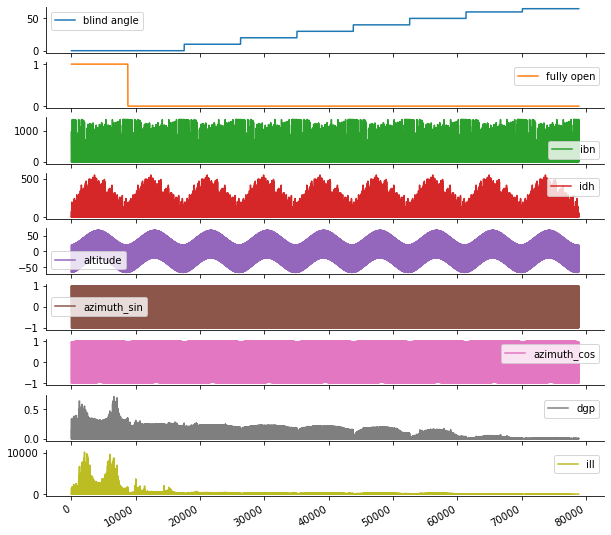

In [25]:
_=df.plot(subplots=True, figsize=(10,10))

### Train, validation and test splits

In [26]:
#saving column names as list
columns = df.columns 

In [27]:
np.random.seed(6)

data = np.array(df)
np.random.shuffle(data)

#splitting the data into train, validation and test sets 70%, 20%, 10%
split_index = len(data)

train = data[0:int(split_index*0.7)]
val = data[int(split_index*0.7):int(split_index*0.9)]
test = data[int(split_index*0.9):]

print("train has shape: " + str(train.shape))
print("val has shape: " + str(val.shape))
print("test has shape: " + str(test.shape))

train has shape: (55188, 9)
val has shape: (15768, 9)
test has shape: (7884, 9)


### Feature normalisation

We will normalise all values apart from sin azmuth and cos azimuth since these values already lie within a range of zero and 1. We will normalise all other features but only use the training set statistics to avoid data leakage

In [28]:
TRAIN_MEAN = train.mean(axis=0)
TRAIN_STD = train.std(axis=0)
NORM_COLS = ['blind angle', 'ibn', 'idh', 'altitude', 'dgp', 'ill']
COLUMN_INDICES = {name: i for i, name in enumerate(columns)}

#saving means and indices 
np.save(data_path + '/means.npy', TRAIN_MEAN) 
np.save(data_path + '/stds.npy', TRAIN_STD) 
np.save(data_path + '/col_indices.npy', COLUMN_INDICES) 

In [29]:
def normalise(dataset, col_indices=COLUMN_INDICES, norm_cols=NORM_COLS,
              train_mean=TRAIN_MEAN, train_std=TRAIN_STD):
    """
    Returns normalised features with mean of zero and std of 1.
    formula is (train - train_mean) / train_std, but we index by indices
    since we dont want to normalise all columns.
    Args:
        dataset: numpy array to normalise
        col_indices -> dict: the indices of cols in dataset
        norm_cols -> list: columns to be normalised
        train_mean -> list: means of train set columns
        train_std -> list: std's of train set columns
    """
    indices = [col_indices[col] for col in norm_cols]
    dataset[:,indices] = (dataset[:,indices] - train_mean[indices]) / train_std[indices]
    return dataset

def reverse_targets(target_scaled, target_name=None):
    
    """
    Takes either a 2d array or single feature and reverses the normalisation step 
    made in the normalise function. Mean and std values are hard-coded.
    Args:
        target_scaled -> numpy array: the target variable(s) to operate on
        target_name -> bool: if operating on a single feature
    """
    
    dgp_mean = 0.03979594875697615
    dgp_std = 0.07610859804304904
    ill_mean = 82.57055868009675
    ill_std = 322.0189517267245
    
    target = target_scaled.copy()
    
    if target_name is None:
        target[:,0] =  (target[:,0] * dgp_std) + dgp_mean
        target[:,1] =  (target[:,1] * ill_std) + ill_mean
        return target
    
    else:
        if target_name == dgp:
            return (target * dgp_std) + dgp_mean
        elif target_name == ill:
            return (target * dgp_ill) + ill_mean

In [30]:
#applying normalisation to train, validation and test sets
train = normalise(train)
val = normalise(val)
test = normalise(test)

#saving training and validation sets to move to GPU
np.save(data_path + '/train.npy', train) 
np.save(data_path + '/valid.npy', val) 

In [31]:
#checking normalisation worked correctly
for dataset in [train, val, test]:
    for name, index in COLUMN_INDICES.items():
        print("%s mean: %.5f, %s std: %.2f" % (name,dataset[:,index].mean(),name,dataset[:,index].std()))
    print('\n')

blind angle mean: -0.00000, blind angle std: 1.00
fully open mean: 0.11033, fully open std: 0.31
ibn mean: 0.00000, ibn std: 1.00
idh mean: -0.00000, idh std: 1.00
altitude mean: 0.00000, altitude std: 1.00
azimuth_sin mean: 0.00206, azimuth_sin std: 0.76
azimuth_cos mean: 0.02411, azimuth_cos std: 0.66
dgp mean: 0.00000, dgp std: 1.00
ill mean: -0.00000, ill std: 1.00


blind angle mean: -0.00971, blind angle std: 1.00
fully open mean: 0.11352, fully open std: 0.32
ibn mean: 0.00260, ibn std: 1.01
idh mean: -0.00783, idh std: 0.98
altitude mean: -0.00083, altitude std: 1.00
azimuth_sin mean: 0.00475, azimuth_sin std: 0.76
azimuth_cos mean: 0.02270, azimuth_cos std: 0.65
dgp mean: 0.00269, dgp std: 1.00
ill mean: -0.00028, ill std: 0.99


blind angle mean: -0.01675, blind angle std: 1.00
fully open mean: 0.11175, fully open std: 0.32
ibn mean: -0.02100, ibn std: 0.97
idh mean: -0.00366, idh std: 0.98
altitude mean: 0.00197, altitude std: 1.00
azimuth_sin mean: -0.01060, azimuth_sin std

The data isnt exactly IID... but its pretty close

## Machine Learning Models

Splitting datasets into x and y

In [32]:
train_x, train_y = train[:,:-2], train[:,-2:]
valid_x, valid_y = val[:,:-2], val[:,-2:]
test_x, test_y = test[:,:-2], test[:,-2:]

Defining some loss functions

In [33]:
def mse_loss(t1, t2):
    return torch.sum((t1-t2)**2) / t1.numel()

def mse(y, yhat):
    """
    Computes MSE - our models loss
    """
    return np.sum((np.array(y) - np.array(yhat))**2) / len(np.array(y))

def mae(y, yhat):
    """
    Computes Mean Absolute Error
    """
    return np.sum(np.abs(np.array(y) - np.array(yhat))) / len(np.array(y))

Custom metrics for illuminance and glare probability accuracy

In [34]:
def accuracy_ill(y_hat, y):
    res = []
    for i in range(len(y)):
        if y[i] > 300:
            res.append(np.abs(y_hat[i] - y[i]) / y[i] < 0.2)
        elif 100 <= y[i] <= 300:
            res.append(np.abs(y_hat[i] - y[i]) / y[i] < 0.1)
        else:
            res.append(np.abs(y_hat[i] - y[i]) < 10)
    return np.mean(res)


def accuracy_dgp(y_hat, y):
        res = []
        for i in range(len(y)):
            if y[i] < 0.35 and y_hat[i] < 0.35:
                res.append(True)
            elif 0.35 <= y[i] < 0.4 and 0.35 <= y_hat[i] < 0.4:
                res.append(True)
            elif 0.4 <= y[i] < 0.45 and 0.4 <= y_hat[i] < 0.45:
                res.append(True)
            elif y[i] >= 0.45 and y_hat[i] >= 0.45:
                res.append(True)
            else:
                res.append(False)
        return np.mean(res)

Creating dictionary for results 

In [35]:
#results dict for training set
results_train = {'index': ['mse_norm_dgp', 'mae_norm_dgp', 'mse_norm_ill', 'mae_norm_ill', 'mse_dgp', 'mae_dgp', 'mse_ill', 'mae_ill', 'acc_ill', 'acc_dgp'],
                 'linear': [],
                 'MLP': [],
                 'XGboost': [],
                 'RF': []}

#results dict for validation set
results_valid = {'index': ['mse_norm_dgp', 'mae_norm_dgp', 'mse_norm_ill', 'mae_norm_ill', 'mse_dgp', 'mae_dgp', 'mse_ill', 'mae_ill', 'acc_ill', 'acc_dgp'],
                 'linear': [],
                 'MLP': [],
                 'XGboost': [],
                 'RF': []}

#results dict for test set
results_test = {'index': ['mse_norm_dgp', 'mae_norm_dgp', 'mse_norm_ill', 'mae_norm_ill', 'mse_dgp', 'mae_dgp', 'mse_ill', 'mae_ill', 'acc_ill', 'acc_dgp'],
                 'linear': [],
                 'MLP': [],
                 'XGboost': [],
                 'RF': []}

#save the empty results  dicts
np.save(data_path + '/train_results.npy', results_train) 
np.save(data_path + '/valid_results.npy', results_valid) 
np.save(data_path + '/test_results.npy', results_test) 

Function to print results and update results dicts

In [36]:
def return_results(preds_train, preds_valid, preds_test, model):
    
    #compute mse and mae for normalised values
    train_mse_norm_dgp, train_mae_norm_dgp = mse(preds_train[:,0], train_y[:,0]), mae(preds_train[:,0], train_y[:,0])
    train_mse_norm_ill, train_mae_norm_ill = mse(preds_train[:,1], train_y[:,1]), mae(preds_train[:,1], train_y[:,1])
    valid_mse_norm_dgp, valid_mae_norm_dgp = mse(preds_valid[:,0], valid_y[:,0]), mae(preds_valid[:,0], valid_y[:,0])
    valid_mse_norm_ill, valid_mae_norm_ill = mse(preds_valid[:,1], valid_y[:,1]), mae(preds_valid[:,1], valid_y[:,1])
    test_mse_norm_dgp, test_mae_norm_dgp = mse(preds_test[:,0], test_y[:,0]), mae(preds_test[:,0], test_y[:,0])
    test_mse_norm_ill, test_mae_norm_ill = mse(preds_test[:,1], test_y[:,1]), mae(preds_test[:,1], test_y[:,1])
    
    #reverse normalisation of preds
    preds_train_rev = reverse_targets(preds_train)
    preds_valid_rev = reverse_targets(preds_valid)
    preds_test_rev = reverse_targets(preds_test)
    
    #reverse normalisation of true Y's
    true_train_rev = reverse_targets(train_y)
    true_valid_rev = reverse_targets(valid_y)
    true_test_rev = reverse_targets(test_y)
    
    #compute mse and mae for reversed normalised values
    train_mse_dgp, train_mae_dgp = mse(preds_train_rev[:,0], true_train_rev [:,0]), mae(preds_train_rev[:,0], true_train_rev [:,0])
    train_mse_ill, train_mae_ill = mse(preds_train_rev[:,1], true_train_rev [:,1]), mae(preds_train_rev[:,1], true_train_rev [:,1])
    valid_mse_dgp, valid_mae_dgp = mse(preds_valid_rev[:,0], true_valid_rev[:,0]), mae(preds_valid_rev[:,0], true_valid_rev[:,0])
    valid_mse_ill, valid_mae_ill = mse(preds_valid_rev[:,1], true_valid_rev[:,1]), mae(preds_valid_rev[:,1], true_valid_rev[:,1])
    test_mse_dgp, test_mae_dgp = mse(preds_test_rev[:,0], true_test_rev[:,0]), mae(preds_test_rev[:,0], true_test_rev[:,0])
    test_mse_ill, test_mae_ill = mse(preds_test_rev[:,1], true_test_rev[:,1]), mae(preds_test_rev[:,1], true_test_rev[:,1])
    
    #compute accuracy illuminance
    acc_ill_train = accuracy_ill(preds_train_rev[:,1], true_train_rev[:,1])
    acc_ill_valid = accuracy_ill(preds_valid_rev[:,1], true_valid_rev[:,1])
    acc_ill_test = accuracy_ill(preds_test_rev[:,1], true_test_rev[:,1])
    
    #compute accuracy dgp
    acc_dgp_train = accuracy_dgp(preds_train_rev[:,0], true_train_rev[:,0])
    acc_dgp_valid = accuracy_dgp(preds_valid_rev[:,0], true_valid_rev[:,0])
    acc_dgp_test = accuracy_dgp(preds_test_rev[:,0], true_test_rev[:,0])
    
    #load the result dicts
    train_results = np.load(data_path + '/train_results.npy',allow_pickle='TRUE').item()
    valid_results = np.load(data_path + '/valid_results.npy',allow_pickle='TRUE').item()
    test_results = np.load(data_path + '/test_results.npy',allow_pickle='TRUE').item()
    
    train_results[model] = [train_mse_norm_dgp, train_mae_norm_dgp, train_mse_norm_ill, 
                            train_mae_norm_ill, train_mse_dgp, train_mae_dgp, train_mse_ill, 
                            train_mae_ill, acc_ill_train, acc_dgp_train]
    
    valid_results[model] = [valid_mse_norm_dgp, valid_mae_norm_dgp, valid_mse_norm_ill, 
                            valid_mae_norm_ill, valid_mse_dgp, valid_mae_dgp, valid_mse_ill, 
                            valid_mae_ill, acc_ill_valid, acc_dgp_valid]
    
    test_results[model] = [test_mse_norm_dgp, test_mae_norm_dgp, test_mse_norm_ill, 
                            test_mae_norm_ill, test_mse_dgp, test_mae_dgp, test_mse_ill, 
                            test_mae_ill, acc_ill_test, acc_dgp_test]
    
    #save the result dicts
    np.save(data_path + '/train_results.npy', train_results) 
    np.save(data_path + '/valid_results.npy', valid_results) 
    np.save(data_path + '/test_results.npy', test_results) 
    
    #print the results
    print("Train normalised MSE glare is:  %.4f" % (train_mse_norm_dgp))
    print("Train normalised MAE glare is:  %.4f" % (train_mae_norm_dgp))
    print("Train MSE glare is:  %.4f" % (train_mse_dgp))
    print("Train MAE glare is:  %.4f" % (train_mae_dgp))
    print("Train normalised MSE illuminance is:  %.4f" % (train_mse_norm_ill))
    print("Train normalised MAE illuminance is:  %.4f" % (train_mae_norm_ill))
    print("Train MSE illuminance is:  %.4f" % (train_mse_ill))
    print("Train MAE illuminance is:  %.4f" % (train_mae_ill))
    print("Train glare accuracy within 10%% tolerance is:  %.4f" % (acc_dgp_train))
    print("Train illuminance accuracy within 10%% tolerance is:  %.4f" % (acc_ill_train))
    print("\n")
    print("Valid normalised MSE glare is:  %.4f" % (valid_mse_norm_dgp))
    print("Valid normalised MAE glare is:  %.4f" % (valid_mae_norm_dgp))
    print("Valid MSE glare is:  %.4f" % (valid_mse_dgp))
    print("Valid MAE glare is:  %.4f" % (valid_mae_dgp))
    print("Valid normalised MSE illuminance is:  %.4f" % (valid_mse_norm_ill))
    print("Valid normalised MAE illuminance is:  %.4f" % (valid_mae_norm_ill))
    print("Valid MSE illuminance is:  %.4f" % (valid_mse_ill))
    print("Valid MAE illuminance is:  %.4f" % (valid_mae_ill))
    print("Valid glare accuracy within 10%% tolerance is:  %.4f" % (acc_dgp_valid))
    print("Valid illuminance accuracy within 10%% tolerance is:  %.4f" % (acc_ill_valid))
    print("\n")
    print("Test normalised MSE glare is:  %.4f" % (test_mse_norm_dgp))
    print("Test normalised MAE glare is:  %.4f" % (test_mae_norm_dgp))
    print("Test MSE glare is:  %.4f" % (test_mse_dgp))
    print("Test MAE glare is:  %.4f" % (test_mae_dgp))
    print("Test normalised MSE illuminance is:  %.4f" % (test_mse_norm_ill))
    print("Test normalised MAE illuminance is:  %.4f" % (test_mae_norm_ill))
    print("Test MSE illuminance is:  %.4f" % (test_mse_ill))
    print("Test MAE illuminance is:  %.4f" % (test_mae_ill))
    print("Test glare accuracy within 10%% tolerance is:  %.4f" % (acc_dgp_test))
    print("Test illuminance accuracy within 10%% percent tolerance is:  %.4f" % (acc_ill_test))

### Pytorch

In [37]:
BATCH_SIZE = 32

NUM_FEATURES = train_x.shape[1]
NUM_LABELS = train_y.shape[1]

train_X, train_Y = torch.from_numpy(train_x), torch.from_numpy(train_y)
valid_X, valid_Y = torch.from_numpy(valid_x), torch.from_numpy(valid_y)
test_X, test_Y = torch.from_numpy(test_x), torch.from_numpy(test_y)

train_df = TensorDataset(train_X, train_Y)
valid_df = TensorDataset(valid_X, valid_Y)

train_dl = DataLoader(train_df, BATCH_SIZE, shuffle=False)
next(iter(train_dl))

[tensor([[-0.0274,  0.0000, -0.4392, -0.6223, -0.9969, -0.9953,  0.0970],
         [ 0.8281,  0.0000, -0.4392, -0.5890,  0.2831, -0.8516, -0.5242],
         [ 1.2558,  0.0000, -0.3943, -0.4783,  0.3678, -0.8968,  0.4424],
         [ 0.4004,  0.0000, -0.4392, -0.3675,  0.5727, -0.8294, -0.5587],
         [-0.0274,  0.0000, -0.4392, -0.6112, -0.6584,  0.8432,  0.5376],
         [-1.3106,  1.0000, -0.4392, -0.6223, -0.7020, -0.0511,  0.9987],
         [-0.0274,  0.0000, -0.4392, -0.5115, -0.3157,  0.9113, -0.4117],
         [-0.8829,  0.0000, -0.4328, -0.1461,  0.8447, -0.1295, -0.9916],
         [-0.0274,  0.0000, -0.4168, -0.6112,  0.2527, -1.0000,  0.0097],
         [-0.8829,  0.0000,  0.4663,  3.4864,  1.5147,  0.9009, -0.4339],
         [-0.8829,  0.0000, -0.4392, -0.6223, -0.6796, -0.9945, -0.1049],
         [ 1.4697,  0.0000, -0.4360,  1.3490,  1.5434, -0.9355, -0.3532],
         [ 1.2558,  0.0000, -0.4392, -0.6223, -1.0268,  0.7702,  0.6378],
         [-0.0274,  0.0000, -0.4392, -

### Linear Regression

In [38]:
#Define model
linear_reg = nn.Linear(NUM_FEATURES, NUM_LABELS)
opt = torch.optim.SGD(linear_reg.parameters(), lr=1e-5)
print(linear_reg.weight)
print(linear_reg.bias)

Parameter containing:
tensor([[ 0.0253,  0.1916, -0.3681,  0.0386,  0.2195, -0.0663,  0.0392],
        [-0.0129, -0.1045,  0.0805, -0.1689,  0.3219, -0.2815,  0.2177]],
       requires_grad=True)
Parameter containing:
tensor([-0.0020, -0.0093], requires_grad=True)


In [39]:
def fit(num_epochs, model, loss_fn, opt):
    
    epoch_number = []
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            y_hat = model(xb.float())
            loss = loss_fn(yb, y_hat)
            loss.backward()
            opt.step()
            opt.zero_grad()
         
        train_loss = loss_fn(model(train_X.float()), train_Y.float())
        val_loss = loss_fn(model(valid_X.float()), valid_Y.float())
        
        epoch_number.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:  
            print('Training loss: %.3f, Validation loss: %.3f' % (train_loss, val_loss))
        
    plt.plot(epoch_number, train_losses, label='Training Loss')
    plt.plot(epoch_number, val_losses, label='Validation Loss')
    plt.legend()
    plt.show()

Training loss: 1.129, Validation loss: 1.119
Training loss: 0.916, Validation loss: 0.906
Training loss: 0.803, Validation loss: 0.793
Training loss: 0.739, Validation loss: 0.730
Training loss: 0.699, Validation loss: 0.691
Training loss: 0.674, Validation loss: 0.665
Training loss: 0.656, Validation loss: 0.647
Training loss: 0.643, Validation loss: 0.634
Training loss: 0.633, Validation loss: 0.624
Training loss: 0.625, Validation loss: 0.616
Training loss: 0.618, Validation loss: 0.609
Training loss: 0.613, Validation loss: 0.604
Training loss: 0.609, Validation loss: 0.600
Training loss: 0.605, Validation loss: 0.596
Training loss: 0.602, Validation loss: 0.593
Training loss: 0.599, Validation loss: 0.590
Training loss: 0.597, Validation loss: 0.588
Training loss: 0.594, Validation loss: 0.585
Training loss: 0.593, Validation loss: 0.584
Training loss: 0.591, Validation loss: 0.582


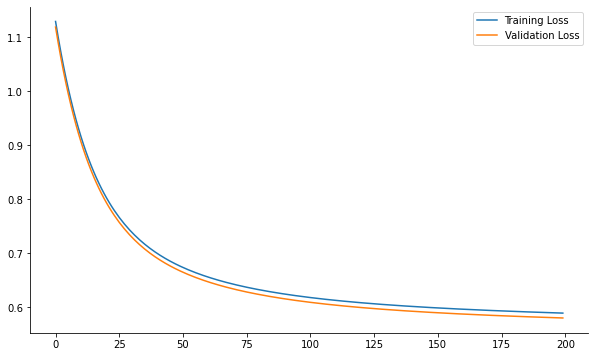

In [40]:
fit(200, linear_reg, mse_loss, opt)

In [41]:
#predict linear regression 
train_preds = np.array(linear_reg(train_X.float()).detach())
valid_preds = np.array(linear_reg(valid_X.float()).detach())
test_preds = np.array(linear_reg(test_X.float()).detach())

return_results(train_preds, valid_preds, test_preds, 'linear')

Train normalised MSE glare is:  0.3701
Train normalised MAE glare is:  0.4634
Train MSE glare is:  0.0021
Train MAE glare is:  0.0353
Train normalised MSE illuminance is:  0.8086
Train normalised MAE illuminance is:  0.3196
Train MSE illuminance is:  83853.6863
Train MAE illuminance is:  102.9273
Train glare accuracy within 10% tolerance is:  0.9983
Train illuminance accuracy within 10% tolerance is:  0.0828


Valid normalised MSE glare is:  0.3697
Valid normalised MAE glare is:  0.4652
Valid MSE glare is:  0.0021
Valid MAE glare is:  0.0354
Valid normalised MSE illuminance is:  0.7911
Valid normalised MAE illuminance is:  0.3179
Valid MSE illuminance is:  82032.0830
Valid MAE illuminance is:  102.3642
Valid glare accuracy within 10% tolerance is:  0.9987
Valid illuminance accuracy within 10% tolerance is:  0.0869


Test normalised MSE glare is:  0.3675
Test normalised MAE glare is:  0.4643
Test MSE glare is:  0.0021
Test MAE glare is:  0.0353
Test normalised MSE illuminance is:  0.886

### Neural Network - Trained outside of notebook on GPU

In [42]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(NUM_FEATURES, 1000)
        self.act1 = nn.ReLU() 
        self.linear2 = nn.Linear(1000, 1000)
        self.act2 = nn.ReLU() 
        self.linear3 = nn.Linear(1000, 1000)
        self.act3 = nn.ReLU() 
        self.linear4 = nn.Linear(1000, NUM_LABELS)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        x = self.act3(x)
        x = self.linear4(x)
        return x

In [43]:
#loading pre-trained model
model = MLP()
model.load_state_dict(torch.load(data_path + "/MLP_state.pth", map_location=torch.device('cpu')))
model.eval()

#checking shapes are correct
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

linear1.weight 	 torch.Size([1000, 7])
linear1.bias 	 torch.Size([1000])
linear2.weight 	 torch.Size([1000, 1000])
linear2.bias 	 torch.Size([1000])
linear3.weight 	 torch.Size([1000, 1000])
linear3.bias 	 torch.Size([1000])
linear4.weight 	 torch.Size([2, 1000])
linear4.bias 	 torch.Size([2])


In [44]:
#preds MLP train, valid and test
with torch.no_grad():
    train_preds = np.array(model(train_X.float()))
    valid_preds = np.array(model(valid_X.float()))
    test_preds = np.array(model(test_X.float()))

In [45]:
#print MLP results and update results dicts
return_results(train_preds, valid_preds, test_preds, 'MLP')

Train normalised MSE glare is:  0.0184
Train normalised MAE glare is:  0.0444
Train MSE glare is:  0.0001
Train MAE glare is:  0.0034
Train normalised MSE illuminance is:  0.0082
Train normalised MAE illuminance is:  0.0205
Train MSE illuminance is:  852.5217
Train MAE illuminance is:  6.6034
Train glare accuracy within 10% tolerance is:  0.9987
Train illuminance accuracy within 10% tolerance is:  0.9556


Valid normalised MSE glare is:  0.0214
Valid normalised MAE glare is:  0.0471
Valid MSE glare is:  0.0001
Valid MAE glare is:  0.0036
Valid normalised MSE illuminance is:  0.0106
Valid normalised MAE illuminance is:  0.0221
Valid MSE illuminance is:  1101.9474
Valid MAE illuminance is:  7.1275
Valid glare accuracy within 10% tolerance is:  0.9987
Valid illuminance accuracy within 10% tolerance is:  0.9561


Test normalised MSE glare is:  0.0211
Test normalised MAE glare is:  0.0470
Test MSE glare is:  0.0001
Test MAE glare is:  0.0036
Test normalised MSE illuminance is:  0.0124
Test 

### XGBoost

Converting data to XGboost matrices

Multi-output regression is not implemented in XGboost, so we have to train two models

Performance on training set is an order of magnitude better on training set than on validation and test sets, however, validation performance does not diverge, and since we use the validation set for early stopping we can be confident the model is not overfitting.

In [46]:
train_dgp = xgb.DMatrix(train_x, label=train_y[:,0].copy())
valid_dgp = xgb.DMatrix(valid_x, label=valid_y[:,0].copy())
test_dgp = xgb.DMatrix(test_x, label=test_y[:,0].copy())

train_ill = xgb.DMatrix(train_x, label=train_y[:,1].copy())
valid_ill = xgb.DMatrix(valid_x, label=valid_y[:,1].copy())
test_ill = xgb.DMatrix(test_x, label=test_y[:,1].copy())

Load the param dictionaries from hyper param training

In [47]:
#load the params dicts
params_dgp = np.load(data_path + '/XG_DGP_PARAMS.npy',allow_pickle='TRUE').item()
params_ill = np.load(data_path + '/XG_ILL_PARAMS.npy',allow_pickle='TRUE').item()

Train model for dgp, using validation set for early stopping

In [ ]:
evals_result = {}

xg_model_dgp = xgb.train(
    params_dgp,
    train_dgp,
    num_boost_round=3000,
    evals=[(train_dgp, "train"),(valid_dgp, "valid")],
    evals_result= evals_result,
    early_stopping_rounds=10
)

clear_output()

fig, ax = plt.subplots(2,1, figsize=(6,8))
ax[0].plot(evals_result['train']['mae'], label = 'Train')
ax[0].plot(evals_result['valid']['mae'], label = 'Valid')
ax[1].plot(evals_result['train']['mae'][-200:], label = 'Train')
ax[1].plot(evals_result['valid']['mae'][-200:], label = 'Valid')
ax[0].legend()
ax[0].title.set_text('Training and validation loss')
ax[1].title.set_text('Training and validation loss zoomed in last 200 boosting rounds')
_= ax[1].legend()


In [ ]:
#Saving model
#joblib.dump(xg_model_dgp, data_path + '/xg_model_dgp') 

In [ ]:
#to load
#joblib.load(data_path + '/xg_model_dgp')

Train model for illuminance, using validation set for early stopping

In [ ]:
evals_result = {}

xg_model_ill = xgb.train(
    params_ill,
    train_ill,
    num_boost_round=3000,
    evals=[(train_ill, "train"), (valid_ill, "valid")],
    evals_result= evals_result,
    early_stopping_rounds=10
)

clear_output()

fig, ax = plt.subplots(2,1, figsize=(6,8))
ax[0].plot(evals_result['train']['mae'], label = 'Train')
ax[0].plot(evals_result['valid']['mae'], label = 'Valid')
ax[1].plot(evals_result['train']['mae'][-200:], label = 'Train')
ax[1].plot(evals_result['valid']['mae'][-200:], label = 'Valid')
ax[0].legend()
ax[0].title.set_text('Training and validation loss')
ax[1].title.set_text('Training and validation loss zoomed in last 200 boosting rounds')
_= ax[1].legend()

In [ ]:
#Saving model
#joblib.dump(xg_model_ill, data_path + '/xg_model_ill') 

Making predictions for both models

In [48]:
#to load
xg_model_dgp = joblib.load(data_path + '/xg_model_dgp')
xg_model_ill = joblib.load(data_path + '/xg_model_ill')

In [49]:
def return_predictions(model_dgp, model_ill, df_dgp, df_ill):
    
    #make preds
    preds_dgp = model_dgp.predict(df_dgp, ntree_limit=model_dgp.best_ntree_limit)
    preds_ill = model_ill.predict(df_ill, ntree_limit=model_ill.best_ntree_limit)
    preds_dgp = preds_dgp.reshape(len(preds_dgp), 1)
    preds_ill = preds_ill.reshape(len(preds_ill), 1)
    #join arrays
    return np.hstack((preds_dgp, preds_ill))

In [50]:
preds_train = return_predictions(xg_model_dgp, xg_model_ill, train_dgp, train_ill)
preds_valid = return_predictions(xg_model_dgp, xg_model_ill, valid_dgp, valid_ill)
preds_test = return_predictions(xg_model_dgp, xg_model_ill, test_dgp, test_ill)

Printing stats

In [51]:
return_results(preds_train, preds_valid, preds_test, 'XGboost')

Train normalised MSE glare is:  0.0002
Train normalised MAE glare is:  0.0037
Train MSE glare is:  0.0000
Train MAE glare is:  0.0003
Train normalised MSE illuminance is:  0.0000
Train normalised MAE illuminance is:  0.0005
Train MSE illuminance is:  0.1319
Train MAE illuminance is:  0.1744
Train glare accuracy within 10% tolerance is:  0.9999
Train illuminance accuracy within 10% tolerance is:  1.0000


Valid normalised MSE glare is:  0.0190
Valid normalised MAE glare is:  0.0302
Valid MSE glare is:  0.0001
Valid MAE glare is:  0.0023
Valid normalised MSE illuminance is:  0.0112
Valid normalised MAE illuminance is:  0.0130
Valid MSE illuminance is:  1164.0964
Valid MAE illuminance is:  4.1970
Valid glare accuracy within 10% tolerance is:  0.9991
Valid illuminance accuracy within 10% tolerance is:  0.9867


Test normalised MSE glare is:  0.0181
Test normalised MAE glare is:  0.0302
Test MSE glare is:  0.0001
Test MAE glare is:  0.0023
Test normalised MSE illuminance is:  0.0099
Test no

### Random Forest

Loading params

In [52]:
params_rf = np.load(data_path + '/RF_PARAMS.npy',allow_pickle='TRUE').item()

In [53]:
#define model
rf = RandomForestRegressor(**params_rf)

In [54]:
#train model 
rf.fit(train_x, train_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [55]:
#make predctions
preds_train = rf.predict(train_x)
preds_valid = rf.predict(valid_x)
preds_test = rf.predict(test_x)

In [56]:
return_results(preds_train, preds_valid, preds_test, 'RF')

Train normalised MSE glare is:  0.0027
Train normalised MAE glare is:  0.0121
Train MSE glare is:  0.0000
Train MAE glare is:  0.0009
Train normalised MSE illuminance is:  0.0033
Train normalised MAE illuminance is:  0.0069
Train MSE illuminance is:  337.9624
Train MAE illuminance is:  2.2107
Train glare accuracy within 10% tolerance is:  0.9995
Train illuminance accuracy within 10% tolerance is:  0.9948


Valid normalised MSE glare is:  0.0191
Valid normalised MAE glare is:  0.0335
Valid MSE glare is:  0.0001
Valid MAE glare is:  0.0025
Valid normalised MSE illuminance is:  0.0144
Valid normalised MAE illuminance is:  0.0174
Valid MSE illuminance is:  1493.1940
Valid MAE illuminance is:  5.6186
Valid glare accuracy within 10% tolerance is:  0.9989
Valid illuminance accuracy within 10% tolerance is:  0.9675


Test normalised MSE glare is:  0.0207
Test normalised MAE glare is:  0.0339
Test MSE glare is:  0.0001
Test MAE glare is:  0.0026
Test normalised MSE illuminance is:  0.0163
Test 

### Plotting results

In [57]:
#load the results
train_results = np.load(data_path + '/train_results.npy',allow_pickle='TRUE').item()
valid_results = np.load(data_path + '/valid_results.npy',allow_pickle='TRUE').item()
test_results = np.load(data_path + '/test_results.npy',allow_pickle='TRUE').item()

#getting indices of indexes
INDICES = {name: i for i, name in enumerate(train_results['index'])}

#some messy operations...

#changing name of keys so that we can directly use keys as labels
train_results['Random Forest'] = train_results.pop('RF')
valid_results['Random Forest'] = valid_results.pop('RF')
test_results['Random Forest'] = test_results.pop('RF')

#Removing index and changing the order of some of the keys now to make plotting easier...
order = ['linear', 'MLP', 'Random Forest', 'XGboost']
TRAIN_RESULTS = {k : train_results[k] for k in order}
VALID_RESULTS = {k : valid_results[k] for k in order}
TEST_RESULTS = {k : test_results[k] for k in order}

In [64]:
def plot_eval_metrics(plot_metric, y_axis, title, train=TRAIN_RESULTS, 
                      valid=VALID_RESULTS, test=TEST_RESULTS, indices=INDICES,
                      plt_grid = False):
    
    train_ = train.copy()
    valid_ = valid.copy()
    test_ = test.copy()
    
    #removing linear regression - the scales are too different...
    del train_['linear']
    del valid_['linear']
    del test_['linear']
    
    train_metric = [v[indices[plot_metric]] for v in train_.values()]
    val_metric = [v[indices[plot_metric]] for v in valid_.values()]
    test_metric = [v[indices[plot_metric]] for v in test_.values()]
    
    plt.style.use('seaborn-pastel')
    
    x = np.arange(len(train_metric))
    width = 0.25
    labels = train_.keys()
    
    fig, ax = plt.subplots(figsize=(12,8), dpi=None)

    plt.grid(False)
    if plt_grid:
        plt.grid(color='k', ls = '-.', lw = 0.2)
    plt.bar(x - 0.27, train_metric, width, label = 'Training set', edgecolor='k')
    plt.bar(x, val_metric, width, label = 'Validation set', edgecolor='k')
    plt.bar(x + 0.27, test_metric, width, label = 'Test set', edgecolor='k')
    plt.ylabel(y_axis, color='k')
    plt.title(title)
    plt.xticks(ticks=x, labels=labels, rotation=0)
    fig.set_facecolor('white')
    ax.set_facecolor('white')
    ax.tick_params(colors='k')
    _ = plt.legend(facecolor='white')

In [65]:
def plot_accuracy(plot_metric, y_axis, title, train=TRAIN_RESULTS, 
                  valid=VALID_RESULTS, test=TEST_RESULTS, indices=INDICES,
                  plt_grid = False):
    
    train_ = train.copy()
    valid_ = valid.copy()
    test_ = test.copy()
    
    train_metric = [v[indices[plot_metric]]*100 for v in train_.values()]
    val_metric = [v[indices[plot_metric]]*100 for v in valid_.values()]
    test_metric = [v[indices[plot_metric]]*100 for v in test_.values()]
    
    plt.style.use('seaborn-pastel')
    
    x = np.arange(len(train_metric))
    width = 0.25
    labels = train_.keys()
    
    fig, ax = plt.subplots(figsize=(12,8), dpi=None)

    plt.grid(False)
    if plt_grid:
        plt.grid(color='k', ls = '-.', lw = 0.2)
    plt.bar(x - 0.27, train_metric, width, label = 'Training set', edgecolor='k', lw = 0.8)
    plt.bar(x, val_metric, width, label = 'Validation set', edgecolor='k', lw = 0.8)
    plt.bar(x + 0.27, test_metric, width, label = 'Test set', edgecolor='k', lw = 0.8)
    plt.ylabel(y_axis, color='k')
    plt.title(title, pad=20)
    plt.xticks(ticks=x, labels=labels, rotation=0)
    for i in ax.patches:
        ax.text(i.get_x()+.0, i.get_height()+1, \
                str(round((i.get_height()), 3)) + '%', fontsize=11, color='dimgrey',
                    rotation=45)
    fig.set_facecolor('white')
    ax.set_facecolor('white')
    ax.tick_params(colors='k')
    _ = plt.legend(facecolor='white')

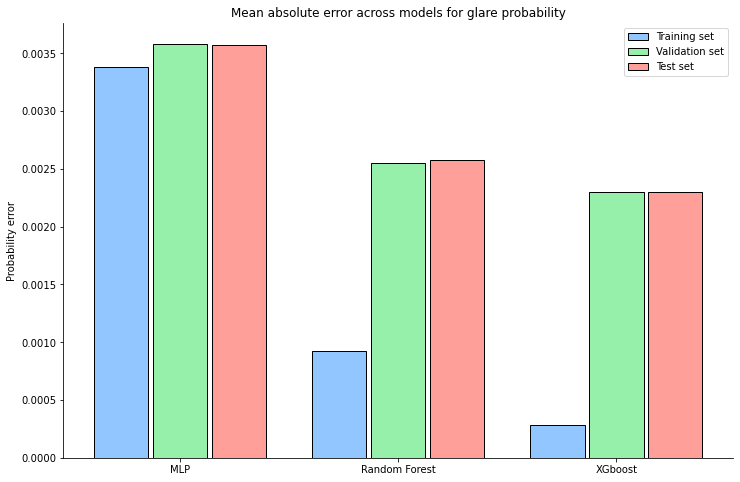

In [66]:
plot_metric = 'mae_dgp'
y_axis = 'Probability error'
title = 'Mean absolute error across models for glare probability'

plot_eval_metrics(plot_metric, y_axis, title, train=TRAIN_RESULTS, 
                      valid=VALID_RESULTS, test=TEST_RESULTS, indices=INDICES)

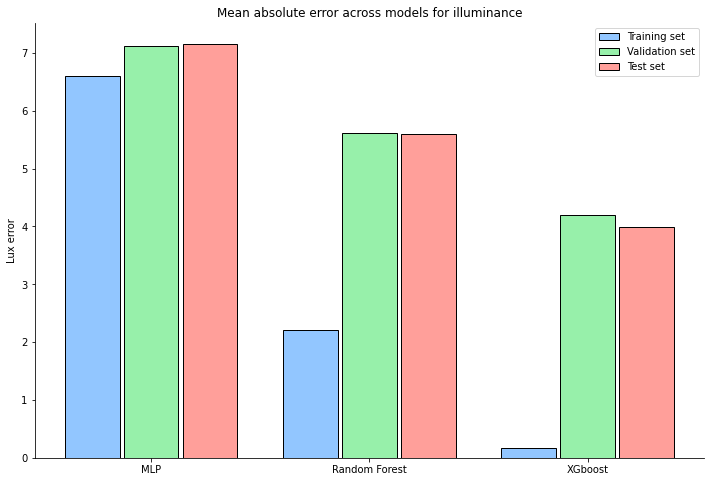

In [67]:
plot_metric = 'mae_ill'
y_axis = 'Lux error'
title = 'Mean absolute error across models for illuminance'

plot_eval_metrics(plot_metric, y_axis, title, train=TRAIN_RESULTS, 
                      valid=VALID_RESULTS, test=TEST_RESULTS, indices=INDICES)

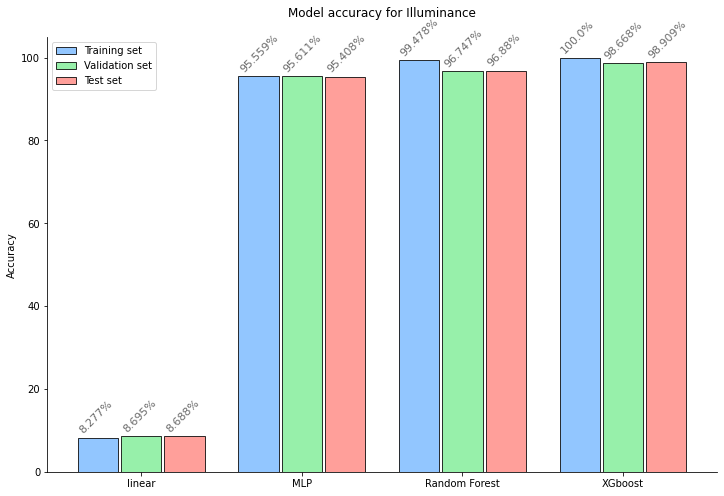

In [68]:
plot_metric= 'acc_ill'
y_axis='Accuracy'
title= 'Model accuracy for Illuminance'

plot_accuracy(plot_metric, y_axis, title)

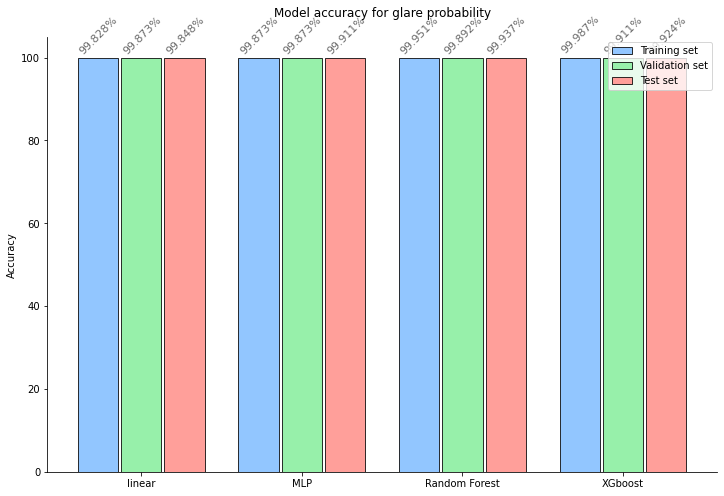

In [69]:
plot_metric= 'acc_dgp'
y_axis='Accuracy'
title='Model accuracy for glare probability'

plot_accuracy(plot_metric, y_axis, title)